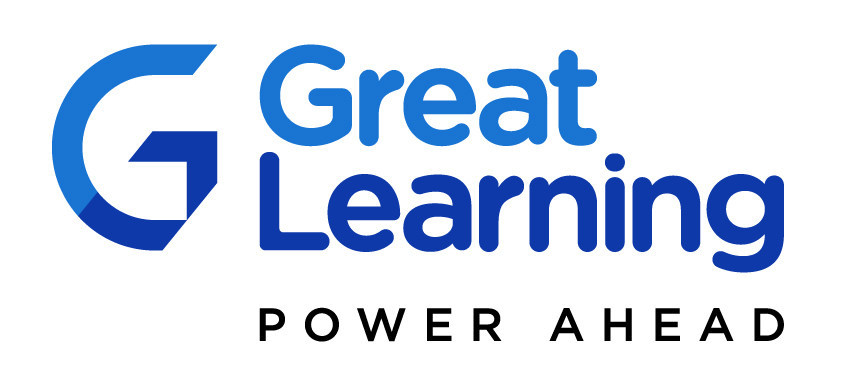

# **LVC 9: Semantic Search with Transformer Embeddings**

# **Semantic Search Demonstration - Quora Similar Question Retrieval**

In this notebook, we shall demonstrate one simple potential application of Semantic Search - **retrieving pre-existing similar question threads to a user query on Quora.** Quora is a thread-based question-and-answer website where users can ask and answer questions on various topics. It was founded in 2009, and has since become a popular platform for knowledge sharing and networking. Users can create their own profiles, follow others, and engage in discussions on a wide range of subjects.


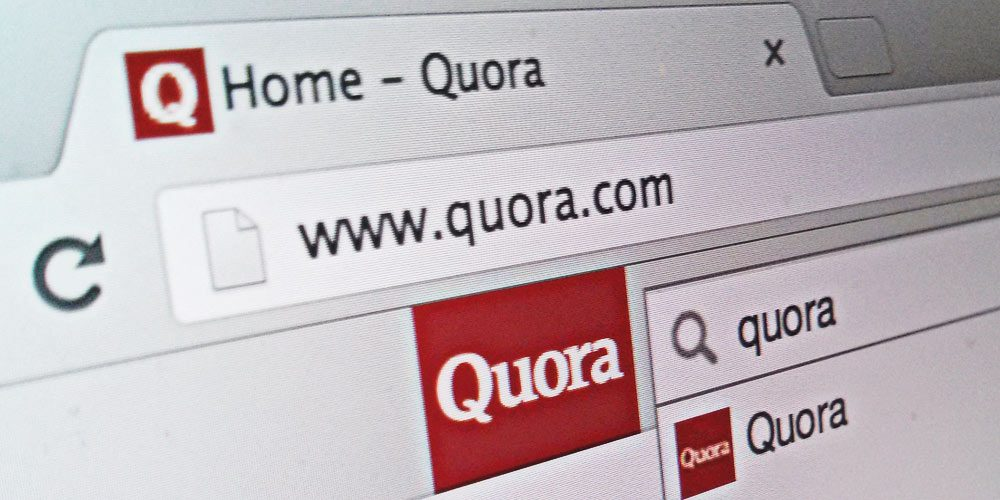

This notebook demonstrates how to use Sentence Transformers and Pinecone to perform Semantic Search on a Quora questions dataset. First, we load the Quora questions dataset, preprocess the data, index the preprocessed data using Pinecone and create a search interface that allows us to input a query and retrieve the most similar Quora questions. We use the Cosine Similarity metric to calculate the similarity between the query and the indexed questions, and return the top K results.

## **Installing the Protocol Buffers library**

The Protocol Buffers (Protobuf) library is a way of serializing structured data in an efficient yet extensible format. It allows developers to define the structure of their data using a simple language, then generate code to work with that data in various programming languages.

In [ ]:
!pip install protobuf==3.19.5

## **Installing a few important packages**

Here's a brief description of the packages we're installing:

- **pinecone-client:** This package provides a Python client for interacting with the Pinecone search engine. It includes functions for indexing and searching data, as well as managing your Pinecone account.

- **datasets:** This package provides a collection of sample datasets that can be used to test the functionality of the Pinecone client. These datasets include things like movie reviews, scientific papers, and news articles.

- **sentence-transformers:** This package provides a set of pre-trained Transformer models for converting text into numerical vectors / embeddings, that can be used for various NLP tasks, such as text classification, sentiment analysis, and machine translation.

In summary, these packages provide a convenient way to interact with the Pinecone search engine and perform various NLP tasks using pre-trained models. In this notebook, we will use Pinecone to index and manage the vector database that will result from using Sentence Transformers to convert text into vector embeddings.

In [ ]:
!pip install -qU \
  "pinecone-client[grpc]"==2.2.1 \
  datasets==2.12.0 \
  sentence-transformers==2.2.2

## **Loading the Quora Questions Dataset**

In [ ]:
from datasets import load_dataset

dataset = load_dataset('quora', split='train[285000:290000]')
dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/404290 [00:00<?, ? examples/s]

Dataset quora downloaded and prepared to /root/.cache/huggingface/datasets/quora/default/0.0.0/36ba4cd42107f051a158016f1bea6ae3f4685c5df843529108a54e42d86c1e04. Subsequent calls will reuse this data.


Dataset({
    features: ['questions', 'is_duplicate'],
    num_rows: 5000
})

## **Viewing the Quora Questions Dataset**

In [ ]:
dataset[:5]

{'questions': [{'id': [251641, 405357],
   'text': ['Why study electric & electrical engineering?',
    'What should I study in electrical engineering?']},
  {'id': [405358, 405359],
   'text': ['Does inhaling vapours of glycerine affect human health?',
    'How can excessive sitting affect human health?']},
  {'id': [8387, 129948],
   'text': ['How do I recover my Facebook email and password?',
    "I forget my Facebook account password and I also can't access to the email address provided, can I reset my password?"]},
  {'id': [164010, 125685],
   'text': ['What is the best movie at theaters now?',
    'What is the best movies to watch?']},
  {'id': [405360, 323845],
   'text': ['How can one enjoy the life at chicago?',
    'What should I do to enjoy my life?']}],
 'is_duplicate': [False, False, True, False, False]}

## **Removing Duplicates**

In [ ]:
questions = []

for record in dataset['questions']:
    questions.extend(record['text'])

# remove duplicates
questions = list(set(questions))
print('\n'.join(questions[:5]))
print(len(questions))

What does Bootstrap do?
Why is drama so addictive?
How does the demonetized notes of 500 and 1000 effect the real estate?
What changes can I make to have a successful life?
What is the finest web hosting service provider in India?
9852


## **Importing the Sentence Transformer Model for Dense Text Embeddings**

We will be using the "all-MiniLM-L6-v2" Sentence Transformer in this notebook, a variant of the Transformer architecture that has been optimized for efficiency and scalability.

The "all-MiniLM-L6-v2" model is a variant of the MiniLM model developed by the Sentence Transformers team. It is a lightweight and efficient language model that uses a smaller number of parameters while still achieving competitive performance on a wide range of NLP tasks. It has only 6 layers and 6 heads, compared to the 12 layers and 12 heads of the original MiniLM model - the Encoder and the Decoder of the Transformer model each consist of 6 identical layers, each of which contains 6 attention heads.

In [ ]:
from sentence_transformers import SentenceTransformer
import torch

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device != 'cuda':
    print(f"You are using {device}. This is much slower than using "
          "a CUDA-enabled GPU. If on Colab you can change this by "
          "clicking Runtime > Change runtime type > GPU.")

model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
model

You are using cpu. This is much slower than using a CUDA-enabled GPU. If on Colab you can change this by clicking Runtime > Change runtime type > GPU.


SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [ ]:
query = 'which city is the most populated in the world?'

xq = model.encode(query)
xq.shape

(384,)

As we can see, the model encodes sentences into a **384-dimensional vector**.

This vector dimension size is a hyperparameter choice, and varies for each Transformer Embedding model.

## **Viewing the Embedding Vector Representation**

In [ ]:
_id = '0'
metadata = {'text': query}

vectors = [(_id, xq, metadata)]

In [ ]:
vectors

[('0',
  array([ 1.50860816e-01,  1.29710445e-02, -5.08222803e-02,  6.06876537e-02,
         -3.35405493e-04, -2.90263221e-02,  5.06248251e-02,  2.99537499e-02,
         -3.10024060e-02,  5.96766360e-02,  5.95133677e-02, -1.33624256e-01,
          7.15944823e-03,  4.92674485e-02,  1.59945600e-02, -2.03522481e-02,
          3.74022536e-02, -9.18012261e-02,  7.44751617e-02, -5.41728660e-02,
         -5.14636189e-02, -4.53633666e-02,  6.31610826e-02,  4.29923423e-02,
          2.43182406e-02,  2.65025981e-02,  1.74598303e-02,  8.24665055e-02,
         -1.59858800e-02, -7.79028842e-03, -1.71448234e-02,  7.63704702e-02,
          1.10217564e-01, -2.29893848e-02,  8.37782491e-03,  7.16603361e-03,
         -5.05503034e-03, -4.04070914e-02,  3.40002254e-02,  3.00653484e-02,
          4.23340611e-02, -2.88223550e-02,  3.75781246e-02, -4.33308184e-02,
          2.17319671e-02,  8.27985164e-03, -1.04310233e-02,  7.60996491e-02,
          3.55796842e-03,  4.72234190e-02,  3.57121266e-02,  7.104719

The above is the 384-dimensional embedding (vector representation) of the text "Which city is the most populated in the world?"

## **Training the Transformer Embedding Model on the Quora Dataset**

In [ ]:
import os
import pinecone

# get api key from app.pinecone.io
api_key = os.environ.get('3493ea9d-0245-492f-a67a-84269b6a97bc') or '3493ea9d-0245-492f-a67a-84269b6a97bc'
# find your environment next to the api key in pinecone console
env = os.environ.get('gcp-starter') or 'gcp-starter'

pinecone.init(
    api_key=api_key,
    environment=env
)

In [ ]:
index_name = 'semantic-search'

In [ ]:
# only create index if it doesn't exist
if index_name not in pinecone.list_indexes():
    pinecone.create_index(
        name=index_name,
        dimension=model.get_sentence_embedding_dimension(),
        metric='cosine' # This metric can be replaced by other similarity metrics, such as Euclidean, Jaccard etc.
    )

# now connect to the index
index = pinecone.GRPCIndex(index_name)

In [ ]:
from tqdm.auto import tqdm

batch_size = 128
vector_limit = 100000

questions = questions[:vector_limit]

for i in tqdm(range(0, len(questions), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(questions))
    # create IDs batch
    ids = [str(x) for x in range(i, i_end)]
    # create metadata batch
    metadatas = [{'text': text} for text in questions[i:i_end]]
    # create embeddings
    xc = model.encode(questions[i:i_end])
    # create records list for upsert
    records = zip(ids, xc, metadatas)
    # upsert to Pinecone
    index.upsert(vectors=records)

# check number of records in the index
index.describe_index_stats()

  0%|          | 0/77 [00:00<?, ?it/s]

{'dimension': 384,
 'index_fullness': 0.88919,
 'namespaces': {'': {'vector_count': 88919}},
 'total_vector_count': 88919}

## **Checking the results - Quora Similar Question Retrieval for a User Query**

In [ ]:
query = "which city has the highest population in the world?"

# create the query vector
xq = model.encode(query).tolist()

# now query
xc = index.query(xq, top_k=5, include_metadata=True)
xc


{'matches': [{'id': '61922',
              'metadata': {'text': 'What country has the biggest population?'},
              'score': 0.7657304,
              'sparse_values': {'indices': [], 'values': []},
              'values': []},
             {'id': '61902',
              'metadata': {'text': 'What is the most isolated city in the '
                                   'world, with over a million metro area '
                                   'inhabitants?'},
              'score': 0.703198,
              'sparse_values': {'indices': [], 'values': []},
              'values': []},
             {'id': '82420',
              'metadata': {'text': 'Which is the most beautiful city in '
                                   'world?'},
              'score': 0.7003918,
              'sparse_values': {'indices': [], 'values': []},
              'values': []},
             {'id': '77478',
              'metadata': {'text': 'Where is the most beautiful city in the '
                            

In [ ]:
for result in xc['matches']:
    print(f"{round(result['score'], 2)}: {result['metadata']['text']}")

0.77: What country has the biggest population?
0.7: What is the most isolated city in the world, with over a million metro area inhabitants?
0.7: Which is the most beautiful city in world?
0.7: Where is the most beautiful city in the world?
0.69: What is the most beautiful city in the world?


In [ ]:
query = "which metropolis has the highest number of people?"

# create the query vector
xq = model.encode(query).tolist()

# now query
xc = index.query(xq, top_k=5, include_metadata=True)
for result in xc['matches']:
    print(f"{round(result['score'], 2)}: {result['metadata']['text']}")

0.67: What is the most isolated city in the world, with over a million metro area inhabitants?
0.6: What is the most dangerous city in USA?
0.6: What is the most dangerous city in USA?
0.59: What country has the biggest population?
0.58: What are the most unsafe cities in America?


In [ ]:
pinecone.delete_index(index_name)

As we can see, despite using only a small Transformer Embedding model, we achieve moderate success in identifying pre-existing Quora questions which have some similar semantic meaning to the user query. Such an application would find use if Quora or a third-party were to create a recommendation system plugin that helps users quickly find pre-existing Quora questions that are similar to what they mean to ask.